## Plot Surface Observations From SynopticData

Visit www.synopticdata.com to sign up for the API to get your own token

In [1]:
import urllib.request as req
from urllib.request import urlopen
import os.path
import json
from datetime import datetime
import re
import numpy as np
import pandas as pd
from metpy.plots import StationPlot, StationPlotLayout, sky_cover, current_weather, wx_code_map
from metpy.calc import wind_components, reduce_point_density
from metpy.units import units
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
class SurfaceMap:
    
    ''' Default settings - look over these '''
    ### SynopticData API root and token, replace with your own token
    API_ROOT = "https://api.synopticdata.com/v2/"
    API_TOKEN = "INSERT API TOKEN HERE"
    units = 'temp|F,speed|kts,pres|mb,height|ft,precip|in,alti|pa' # Get units in correct form
    window = '60' # Window of time to look for obs before ob time, in minutes
    
    
    def __init__(self, validTime, mapExtent, stnDensity):
        ''' Setting up query parameters'''
        self.validTime = validTime
        self.mapExtent = mapExtent
        self.stnDensity = stnDensity
    
            
    # Some methods
    def plot_data(self):
        ''' Plot data on a cartopy map  '''
        data = self.get_station_data()
        # Convert to format metpy can handle - metpy wants lists of each variable, not dictionaries for each station
        data = pd.DataFrame(data).to_dict('list')
        
        # Set up cartopy map
        mapproj = ccrs.Miller(central_longitude=(self.mapExtent[1]+self.mapExtent[0])/2)
        # Create figure and set map extent
        fig = plt.figure(1, figsize=(20,16))
        ax = plt.subplot(111, projection=mapproj)
        ax.set_extent(self.mapExtent, ccrs.PlateCarree())

        # GIS features
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
        ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8)
        ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
        
        # Map titles
        plt.title('Surface Observations', loc='left', fontweight='bold', fontsize=14)
        plt.title(datetime.strftime(self.validTime, 'Valid %H:%Mz %B %m %Y'), loc='right', fontsize=14)

        # Custom layout to format temp and dewpoint
        custom_layout = StationPlotLayout()
        custom_layout.add_value('NW', 'temp', fmt='.0f', units='degF', color='darkred')
        custom_layout.add_value('SW', 'dew', fmt='.0f', units='degF', color='darkgreen')

        # Station plot
        stationplot = StationPlot(ax, np.array(data['lon']), np.array(data['lat']), clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

        u, v = wind_components(np.array(data['wind']) * units('knots'), np.array(data['dir']) * units.degree)
        stationplot.plot_barb(u,v, sizes={'emptybarb':0}, linewidth=0.5)
        stationplot.plot_symbol('C', data['cloud'], sky_cover)
        stationplot.plot_symbol('W', data['wx'], current_weather, fontsize=14)
        stationplot.plot_parameter('NE', data['slp'], formatter=lambda v: format(10 * v, '.0f')[-3:], fontweight='bold')
        stationplot.plot_text((2,-0.5), data['stid'])
        custom_layout.plot(stationplot, data)
        
    
    def get_station_data(self):
        ''' Process the data returned by the query '''
        stnData = self.get_synopticdata_data()
        data = []
        for stn in stnData:
            stid = stn['STID']
            lat = float(stn['LATITUDE'])
            lon = float(stn['LONGITUDE'])
            try:
                metar = stn['OBSERVATIONS']['metar_value_1']['value']
            except KeyError:
                metar = None

            # Match and assign cloud cover code
            try:
                match = re.findall(self.cloud_re, metar)
                cloud_cover = max(np.array([self.get_cloud_cover(cloud) for cloud in match]))
                cloud_cover = int(cloud_cover*8.)
            except:
                cloud_cover = 10 # Not reported

            # Match and assign present weather code
            try:
                match = re.findall(self.wx_re, metar)
                wx = match[0] # Only consider first wx condition
                pres_wx = wx_code_map[str(wx)]
            except:
                pres_wx = 0 # Not reported

            # Get temp, dewpoint, wind, direction, slp
            try:
                temp = float(stn['OBSERVATIONS']['air_temp_value_1']['value'])
            except KeyError:
                temp = None
            try:
                dew = float(stn['OBSERVATIONS']['dew_point_temperature_value_1']['value'])
            except KeyError:
                dew = None
            try:
                wind = float(stn['OBSERVATIONS']['wind_speed_value_1']['value'])
            except KeyError:
                wind = None
            try:
                direction = float(stn['OBSERVATIONS']['wind_direction_value_1']['value'])
            except KeyError:
                direction = None
            try:
                slp = float(stn['OBSERVATIONS']['sea_level_pressure_value_1']['value'])
            except KeyError:
                slp = None

            # Populate dictionary and append to data list
            stndata={'stid':stid,'lat':lat,'lon':lon,'temp':temp, 'dew':dew, 'slp':slp, 'wind':wind, 'dir':direction, 'cloud':cloud_cover, 'wx':pres_wx, 'metar':metar}
            data.append(stndata)
        
        return data
    
        
    def get_synopticdata_data(self):
        ''' Gets station data based on query parameters'''
        api_request_url = os.path.join(self.API_ROOT, "stations/nearesttime")
        stations = self.query_asos()
        time = datetime.strftime(self.validTime, '%Y%m%d%H%M')
        api_request_url += "?token={}&stid={}&attime={}&within={}&units={}".format(self.API_TOKEN, stations, time, self.window, self.units)
        response = req.urlopen(api_request_url)
        api_text_data = response.read()
        use_data = json.loads(api_text_data)
        stnData = use_data['STATION']
        
        return stnData
        
        
    def query_asos(self):
        ''' Return list of ASOS stations to query synopticdata database with '''
        stations = self.asos_list()
        stations = [stn['id'] for stn in stations]
        stations = ",".join(stations)
        
        return stations
    
    
    def asos_list(self):
        ''' Return a list of ASOS stations in specified map extent and plotting density '''
        fh = urlopen('http://weather.rap.ucar.edu/surface/stations.txt') # Station list is from this text file
        lines = fh.readlines()
        lines = [line.decode("utf-8") for line in lines]

        data = []
        for line in lines:
            comment_match = re.search('^!', line)
            blank_match = re.search('^\s*$', line)
            header_match = re.search('\d{2}-\w{3}-\d{2}|CD\s+STATION', line)
            if comment_match or blank_match or header_match:
                None
            else:
                ICAO = line[20:24].strip()
                if len(ICAO) == 4:
                    LATLON = line[39:54]
                    if LATLON[5] == 'S':
                        LAT = float("{0:.2f}".format(-(float(LATLON[0:2])+float(LATLON[3:5])/60.)))
                    if LATLON[5] == 'N':
                        LAT = float("{0:.2f}".format((float(LATLON[0:2])+float(LATLON[3:5])/60.)))
                    if LATLON[14] == 'W':
                        LON = float("{0:.2f}".format(-(float(LATLON[8:11])+float(LATLON[12:14])/60.)))
                    if LATLON[14] == 'E':
                        LON = float("{0:.2f}".format((float(LATLON[8:11])+float(LATLON[12:14])/60.)))
                    PRIORITY = 1/(float(line[-5].strip())+1)
                    stn_dict = {'id':ICAO, 'lat':LAT, 'lon':LON, 'priority':PRIORITY}
                    data.append(stn_dict)

        stns = [(stndict['lat'], stndict['lon']) for stndict in data] 
        priority = [stndict['priority'] for stndict in data]
        mask = reduce_point_density(np.array(stns), self.stnDensity, priority=priority)
        stns = np.array(data)[mask]
        stns = [stn for stn in stns if stn['lon']>self.mapExtent[0] and stn['lon']<self.mapExtent[1] and 
                stn['lat']>self.mapExtent[2] and stn['lat']<self.mapExtent[3]]

        return stns

    
    def get_cloud_cover(self, code):
        ''' Turn cloud cover code into cloud fraction for plotting '''
        if 'OVC' in code:
            return 1.0
        elif 'VV' in code:
            return 1.0
        elif 'BKN' in code:
            return 6.0/8.0
        elif 'SCT' in code:
            return 4.0/8.0
        elif 'FEW' in code:
            return 2.0/8.0
        else:
            return 0
    
    # Regex for metar parsing
    cloud_re = re.compile('VV|FEW|SCT|SKC|CLR|BKN|OVC')
    wx_re = re.compile('(TSNO|VA|FU|HZ|DU|BLDU|SA|BLSA|VCBLSAVCBLDU|BLPY|PO|VCPO|VCDS|VCSS|BR|BCBR|BC|MIFG|VCTS|VIRGA \
                           |VCSH|TS|THDR|VCTSHZ|TSFZFG|TSBR|TSDZ|SQ|FC|\+FC|DS|SS|DRSA|DRDU|TSUP|\+DS|\+SS|-BLSN|BLSN|\+BLSN| \
                           VCBLSN|DRSN|\+DRSN|VCFG|BCFG|PRFG|FG|FZFG|-VCTSDZ|-DZ|-DZBR|VCTSDZ|DZ|\+VCTSDZ|\+DZ|-FZDZ|-FZDZSN| \
                           FZDZ|\+FZDZ|FZDZSN|-DZRA|DZRA|\+DZRA|-VCTSRA|-RA|-RABR|VCTSRA|RA|RABR|RAFG|\+VCTSRA|\+RA|-FZRA| \
                           -FZRASN|-FZRABR|-FZRAPL|-FZRASNPL|TSFZRAPL|-TSFZRA|FZRA|\+FZRA|FZRASN|TSFZRA|-DZSN|-RASN|-SNRA|-SNDZ| \
                           RASN|\+RASN|SNRA|DZSN|SNDZ|\+DZSN|\+SNDZ|-VCTSSN|-SN|-SNBR|VCTSSN|SN|\+VCTSSN|\+SN|VCTSUP|IN|-UP|UP| \
                           \+UP|-SNSG|SG|-SG|IC|-FZDZPL|-FZDZPLSN|FZDZPL|-FZRAPLSN|FZRAPL|\+FZRAPL|-RAPL|-RASNPL|-RAPLSN| \
                           \+RAPL|RAPL|-SNPL|SNPL|-PL|PL|-PLSN|-PLRA|PLRA|-PLDZ|\+PL|PLSN|PLUP|\+PLSN|-SH|-SHRA|SH|SHRA|\+SH| \
                           \+SHRA|-SHRASN|-SHSNRA|\+SHRABR|SHRASN|\+SHRASN|SHSNRA|\+SHSNRA|-SHSN|SHSN|\+SHSN|-GS|-SHGS|FZRAPLGS| \
                           -SNGS|GSPLSN|GSPL|PLGSSN|GS|SHGS|\+GS|\+SHGS|-GR|-SHGR|-SNGR|GR|SHGR|\+GR|\+SHGR|-TSRA|TSRA|TSSN| \
                           TSPL|-TSDZ|-TSSN|-TSPL|TSPLSN|TSSNPL|-TSSNPL|TSRAGS|TSGS|TSGR|\+TSRA|\+TSSN|\+TSPL|\+TSPLSN|TSSA| \
                           TSDS|TSDU|\+TSGS|\+TSGR)')

In [3]:
# Return a list of station data with specified query paramaters
obs = SurfaceMap(validTime=datetime.utcnow(), mapExtent=[-97,-77,35,45], stnDensity=1.2) # Larger density = more sparse
obs.get_station_data()

[{'stid': 'KCNU',
  'lat': 37.67028,
  'lon': -95.48417,
  'temp': 66.2,
  'dew': 60.98,
  'slp': 1008.2,
  'wind': 14.0,
  'dir': 200.0,
  'cloud': 6,
  'wx': 0,
  'metar': 'METAR KCNU 191555Z AUTO 20014KT 10SM BKN012 BKN030 19/16 A2980'},
 {'stid': 'KMHK',
  'lat': 39.13528,
  'lon': -96.67778,
  'temp': 68.0,
  'dew': 60.98,
  'slp': 1005.1,
  'wind': 9.99,
  'dir': 200.0,
  'cloud': 6,
  'wx': 63,
  'metar': 'KMHK 191552Z 20010KT 10SM FEW075 BKN090 20/16 A2969 RMK AO2  RAB1453E05 SLP051 P0000 T02000161'},
 {'stid': 'KOMA',
  'lat': 41.3119,
  'lon': -95.90185,
  'temp': 51.8,
  'dew': 50.0,
  'slp': 1005.5,
  'wind': 11.0,
  'dir': 350.0,
  'cloud': 8,
  'wx': 0,
  'metar': 'METAR KOMA 191555Z AUTO 35011KT 10SM OVC005 11/10 A2969'},
 {'stid': 'KFSD',
  'lat': 43.57694,
  'lon': -96.75361,
  'temp': 42.08,
  'dew': 39.02,
  'slp': 1011.8,
  'wind': 11.99,
  'dir': 40.0,
  'cloud': 8,
  'wx': 61,
  'metar': 'KFSD 191556Z 04012KT 5SM -RA BR OVC006 06/04 A2985 RMK AO2 SLP118  P0001 T00

/home/kschneider/anaconda3/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/kschneider/anaconda3/lib/python3.7/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/home/kschneider/anaconda3/lib/python3.7/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


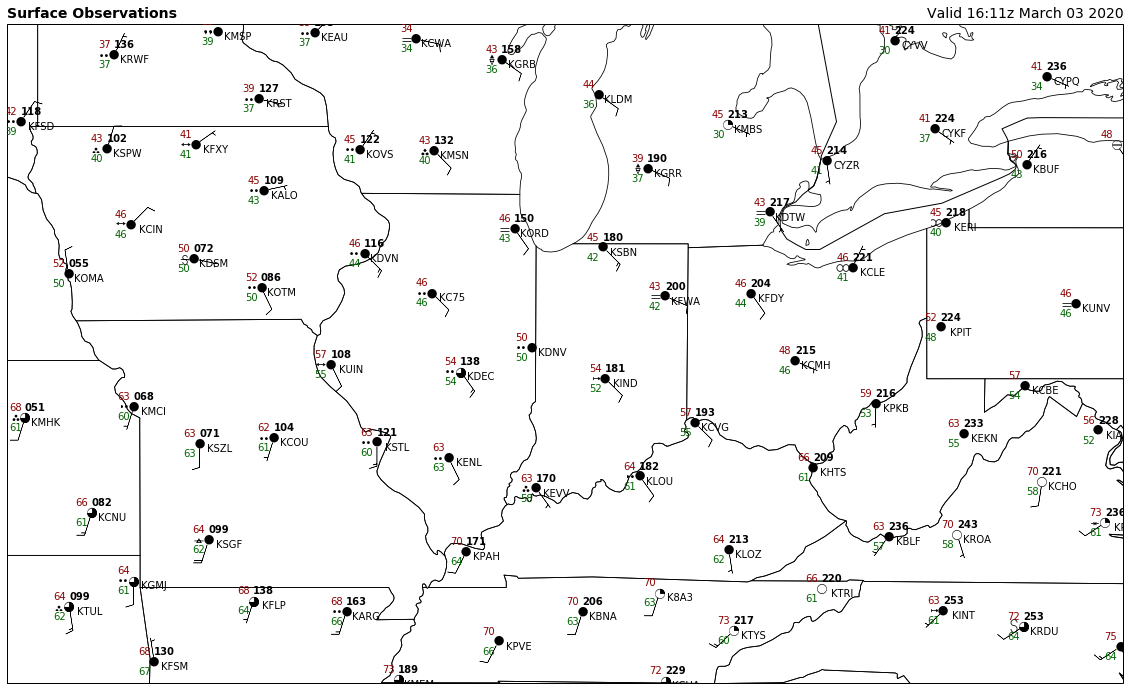

In [4]:
# Plot the data on a map
obs = SurfaceMap(validTime=datetime.utcnow(), mapExtent=[-97,-77,35,45], stnDensity=1.2)
obs.plot_data()